# Dramatic shifts isolation in CMIP6
J. R. Angevaare <joran.angevaare@knmi.nl>

2024 11 27

last update: 2024 12 03

## Software installation
This notebook has several requirements. Most notably [`optim_esm_tools`](https://github.com/JoranAngevaare/optim_esm_tools) (version 3.0.0 or higher).

This requires a conda environment with:
 - `R`
 - `cdo`
 - `cartopy`

Methods of installing this in a new conda environment with python 3.8 or higher can be found in this github repository:
[`optim_esm_base`](https://github.com/JoranAngevaare/optim_esm_base)

**A working example for python 3.8.19 is available: [here](https://github.com/JoranAngevaare/optim_esm_base?tab=readme-ov-file#partial-installation-on-linux-without-synda)**


## Introduction
In order to isolate dramatic shifts in CMIP6 data we need to go through several steps. These steps are schematically:

<img src="workflow.png" alt="drawing" width="500"/>

Similarly, we will use these sequence of steps in this notebook:

  0. [Data preperation](#0.-Data-preperation)
  1. [Preprossessing](#1.-Preprossessing)
  2. [Region isolation](#2.-Region-isolation)
  3. [Formal criteria / region caracterization](#3.-Formal-criteria-/-region-caracterization)
  4. Variable and ensamble grouping (not covered here)

### Simple first
We first do a *simple and minimal* explanation of [Region isloation](#2.-Region-isloation) and [Formal criteria / region caracterization](#3.-Formal-criteria-/-region-caracterization) followed by **[Full-scale workflow](#4.-Full-scale-workflow)**.

## Imports, machine setup

In [1]:
start = !date

In [2]:
import optim_esm_tools as oet
import os
import numpy as np


import matplotlib.pyplot as plt
import glob
import pandas as pd
import logging
import tempfile
import inspect
import datetime

In [3]:
logger = oet.get_logger('EXAMPLE')
logger.setLevel(logging.WARNING)

Let's print some relevant versions

In [4]:
oet.print_versions(
    'optim_esm_tools cartopy numpy numba matplotlib'.split(), print_output=False
)

,module,version,path,git
0,python,3.8.16,/home/aangevaare/miniconda3/envs/py38/bin/python,None
1,optim_esm_tools,3.1.0,/home/aangevaare/software/optim_esm_tools/opti...,branch:add_drop_field_to_read_ds | 09a3c7f
2,cartopy,0.21.0,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
3,numpy,1.24.3,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
4,numba,0.57.1,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
5,matplotlib,None,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None


## 0. Data preperation

First we need to setup some method of obtaining data. We'll just provide one working example, but for a large scale application one has to make use of tools like `synda`, `ESGF`, `esgpull` or `intake-esm`.


### Download some example data using `intake-esm`
Below we use `intake-esm` to download one MOHC dataset.

It's advisable to use the ESGF folder structure as some subroutines are based on that. It's not essential, but does make things easier.

In [5]:
col = oet._test_utils.cmip_store()

we will download one dataset (SSP370, historical and pi-control) and store it in the `WORK_DIR`

In [6]:
WORK_DIR = "/data/volume_2/temp/example_notebook_v4"

if not os.path.exists(WORK_DIR):
    WORK_DIR = tempfile.mkdtemp()
    logger.warning(f"Using {WORK_DIR} you may have limited space here")

In [7]:
query = dict(
    variable_id="sos",
    table_id="Omon",
    source_id="GISS-E2-1-G",
    member_id=[
        "r2i1p5f1",
        "r1i1p5f1",
    ],
    experiment_id=[
        "piControl",
        "historical",
        "ssp245",
    ],
)

In [8]:
search = col.search(**query)

In [9]:
search.keys_info()

,activity_id,institution_id,source_id,experiment_id,table_id,grid_label
key,,,,,,
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn,CMIP,NASA-GISS,GISS-E2-1-G,historical,Omon,gn
CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn,CMIP,NASA-GISS,GISS-E2-1-G,piControl,Omon,gn
ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn,ScenarioMIP,NASA-GISS,GISS-E2-1-G,ssp245,Omon,gn


In [ ]:
ddict = search.to_dataset_dict(
    xarray_open_kwargs={"use_cftime": True},
)

load py-cdo - if we are writing the files we use CDO to calculate the yearly means

In [11]:
import cdo as cdo_module

cdo = cdo_module.Cdo()

### First data preperation: yearly averaging
We first take the yearly averages of the data. That makes the data much lighter and easer to handle.

We store the zar-files to disk and then calculate the yearly averages.

In [12]:
folders = {}
for key, data in ddict.items():
    folder_structure = key.split(".")
    folder_structure.insert(4, "{VARIANT_LABEL}")
    folder_structure.insert(6, "{VARIABLE_ID}")
    folder_structure.append("v20241126")

    path_fmt = os.path.join(WORK_DIR, *folder_structure)

    for variant_label in np.unique(data["member_id"]):
        ds = data.sel(member_id=variant_label)
        ds = ds.isel(dcpp_init_year=0)

        os.makedirs(
            save_in := path_fmt.format(
                VARIANT_LABEL=variant_label, VARIABLE_ID=ds.attrs["variable_id"]
            ),
            exist_ok=True,
        )

        logger.warning(f"Writing {key} to {save_in}")
        folders[f"{key}.{variant_label}"] = save_in

        if os.path.exists(yearly_file := os.path.join(save_in, "merged.nc")):
            continue
        if not os.path.exists(monthly_file := os.path.join(save_in, "monthly.nc")):
            ds.to_netcdf(monthly_file)
        cdo.yearmonmean(input=monthly_file, output=yearly_file)
        for f in monthly_file, yearly_file:
            assert os.path.exists(f), f"Missing {f}"

03-20 13:23:04 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn to /data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/piControl/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
03-20 13:23:04 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn to /data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
03-20 13:23:04 | EXAMPLE      | WARNING  | Writing CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn to /data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
03-20 13:23:04 | EXAMPLE      | WARNING  | Writing ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn to /data/volume_2/temp/example_notebook_v4/ScenarioMIP/NASA-GISS/GISS-E2-1-G/ssp245/r1i1p5f1/Omon/sos/gn/v20241126 | <module> (l. 21)
03-20 13:23:04 | EXAMPLE      | WARNING  | Writing ScenarioMIP.NASA-GISS.GISS-E2-1-G

### Folders in WORK_DIR
You can now examine the folfders in `WORK_DIR`, let's see that there are indeed files there

In [13]:
!ls $WORK_DIR/*/*/GISS-E2-1-G/*/*/*/*/*/* -lthra

for monthly_file in glob.glob(f'{WORK_DIR}/*/*/GISS-E2-1-G/*/*/*/*/*/*/monthly.nc'):
    logger.warning(f'Removing {monthly_file} - we don\'t need it anymore')
    os.remove(monthly_file)

/data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p5f1/Omon/sos/gn/v20241126:
total 8.3M
drwxrwxr-x 3 aangevaare aangevaare   31 Mar 13 15:43 ..
-rw-rw-r-- 1 aangevaare aangevaare 8.3M Mar 13 15:43 merged.nc
drwxrwxr-x 2 aangevaare aangevaare   31 Mar 13 15:43 .

/data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p5f1/Omon/sos/gn/v20241126:
total 8.3M
drwxrwxr-x 3 aangevaare aangevaare   31 Mar 13 15:43 ..
-rw-rw-r-- 1 aangevaare aangevaare 8.3M Mar 13 15:43 merged.nc
drwxrwxr-x 2 aangevaare aangevaare   31 Mar 13 15:43 .

/data/volume_2/temp/example_notebook_v4/ScenarioMIP/NASA-GISS/GISS-E2-1-G/ssp245/r1i1p5f1/Omon/sos/gn/v20241126:
total 4.4M
drwxrwxr-x 3 aangevaare aangevaare   31 Mar 13 15:43 ..
-rw-rw-r-- 1 aangevaare aangevaare 4.4M Mar 13 15:43 merged.nc
drwxrwxr-x 2 aangevaare aangevaare   31 Mar 13 15:43 .

/data/volume_2/temp/example_notebook_v4/CMIP/NASA-GISS/GISS-E2-1-G/piControl/r1i1p5f1/Omon/sos/gn/v20241126:


## 1. Preprossessing

The preprocessing we next apply is all encapsulated in the function `optim_esm_tools.analyze.cmip_handler.read_ds`. We do the following steps:

   1. Do some rudimentary checks like the length of the time series (no duplicate years allowed).
   2. Regrid to a gausian n90 grid (see the config below for changing or setting this variable).
   3. Optionally, add the historical run to the ssp run.
   4. Add some fields to the data that are usefull in the following steps:
       - The 10-year running mean of the time series
       - The detrended time series
       - The 10-year running mean of the detrended time series
   
   5. Add some two-dimentional maps of the variable of interest that are usefull for isolating regions:
      - start end difference
      - std detrended
      - std detrended yearly
      - max jump
      - max jump yearly
      - max derivative
      - percentile score std and max jump
      - max jump div. std
      
For any of the two-dimentional maps in step 5, one can simply do something like `ds_ssp['start end difference'].long_description` to get more information 

### Configuration file
We have a configuration file for `optim_esm_tools` (which you can set through an environment variable `OPTIM_ESM_CONFIG`) that keeps track of several design and analysis choices that went into the code. For example the running mean averaging with a 10-year window is set in `oet.config.config['analyze']['moving_average_years']` while the `n90` grid is similarly set in `oet.config.config['analyze']['regrid_to']`.

The config file currently is located at:

In [14]:
os.path.normpath(oet.config.config_path)

'/home/aangevaare/software/optim_esm_tools/optim_esm_tools/optim_esm_conf.ini'

## Very low spatial resolution for testing
Let's set the spatial resolution to a very small number (n30) such that everything runs fast and stays lightweight

In [15]:
oet.config.config.read_dict({'analyze': {'regrid_to': 'n30'}})

### `optim_esm_tools.analyze.cmip_handler.read_ds`
Below, we apply all the above mentioned pre-processing on the `merged.nc` files that are in the `folders`-dict we defined above.

We load "three" sets 
    - `ds_ssp` which is _just_ the ssp370 scenario. We use this for region finding
    - `ds_his_ssp`, which combines the historical and ssp370 scenario. We use this for evaluating if a selected region will be considered a dramatic shift.
    - `ds_pi`, is the pi-control. We also use this for evaluating if a selected region will be considered a dramatic shift.
    
#### Why `ds_ssp` and `ds_his_ssp`?
One might wonder why we use `ds_ssp` and `ds_his_ssp`. The reason is that the region finding uses the linearly detrended time series. This is arguably a reasonable tool for the scenario-run but if we also add the historical run and then detrend it linearly, we get vastly different results for the different `ssp's` because the forcing between the year 1850 and 2100+ is very non-linear. 

That said, we only need the 2d maps explained under point 5 in [Preprossessing](#1.-Preprossessing). We can ommit the time-eries by adding the field `drop_variable_fields=True` to `oet.read_ds` below.

The tools that use these linearly detrended are used later in the [Full-scale workflow](#4.-Full-scale-workflow) section.

In [16]:
# Preprocessing
ds_ssp = oet.read_ds(
    folders["ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn.r2i1p5f1"],
    add_history=False,
    drop_variable_fields=True,
    max_time=None,
)
# You don't have to specify the historical path if the ESGF file-structure is followed
ds_his_ssp = oet.read_ds(
    folders["ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Omon.gn.r2i1p5f1"],
    add_history=True,
    max_time=None,
)
ds_pi = oet.read_ds(
    folders["CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn.r1i1p5f1"],
    add_history=False,
    max_time=None,
)

## 2. Region isolation

We will now first use an extremely simple method of finding regions - by selecting regions with a medeterianian climate. This is just an example - there are many more advanced methods (also detailed below).

In [17]:
masks, data_points = oet.region_finding.named_region.Medeteranian(ds_ssp).get_masks()

The `masks` are a set of boolean arrays that mask the gridpoints in the datatset, the `data_points` have the actual lon, lat coordinates corresponding to `masks`. We'll scatter the latter below for simplicity.

Text(0.5, 0.98, 'Medeteranian regions as an example of masked regions')

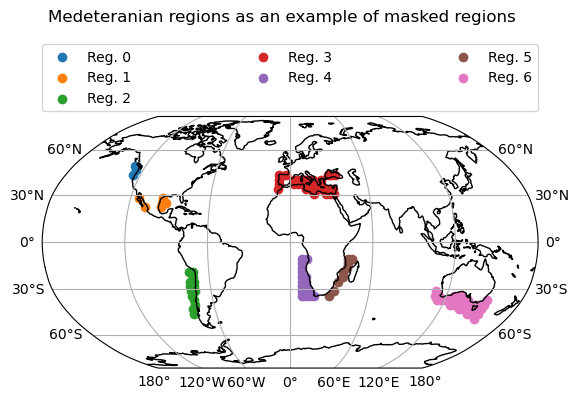

In [18]:
# Wrapper for cartopy.
oet.plotting.plot.setup_map()
for i, m in enumerate(data_points):
    plt.scatter(
        *m.T, transform=oet.plotting.plot.get_cartopy_transform(), label=f"Reg. {i}"
    )

    plt.gca().set_global()
plt.legend(**oet.utils.legend_kw())
plt.suptitle("Medeteranian regions as an example of masked regions")

## 3. Formal criteria / region caracterization
We will now see if the regions selected above are "dramatic". For that purpose, we classify the data using methods that are accumulated in `optim_esm_tools.analyze.region_calculation.RegionPropertyCalculator`.

First let's check if for example the region 6, near south-Australia passes our criteria. Here we finally use `ds_his_ssp` and `ds_pi`.

In [19]:
mask_south_australia = masks[6]

In [20]:
calculator = oet.analyze.region_calculation.RegionPropertyCalculator(
    ds_global=ds_his_ssp, ds_pi=ds_pi, mask=mask_south_australia
)

In [21]:
doc = calculator.calculate()

/home/aangevaare/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### calculated properties
Below, we have the calculated properties that are associated to this combination of `ds_his_ssp`, `ds_pi`, `mask_south_australia`. These fields are shorthand for fields in `2024_11_11_dramatic_shifts_v17_compressed.pdf`. Explaining all shorthand notations is beyond the scope of this example, but you can either read the code of `oet.analyze.region_calculation.RegionPropertyCalculator` or reach out to Joran.


A few examples of fields and their significance in `2024_11_11_dramatic_shifts_v17_compressed.pdf`:
  - `J2_rm` = $J2$
  - `max_jump` = $MJ/\sigma_{PiC}$
  - `se_std_trop_domain` = $SE/\bar{\sigma}_\text{trop}$
  - `rho10_50` = $SE/\rho_{10}^{50}$ (which may seem a bit confusing) see footnote 1. in the dramatic-shifts pdf)

In [22]:
pd.DataFrame(
    np.transpose([list(doc), list(doc.values())]), columns="property value".split()
).sort_values("property")

,property,value
4,J2_min0_rm,-1.6821805040440934
3,J2_rm,1.366616968677499
11,_frac_norm,nan
12,_frac_rho10_50,0.021549224100918713
26,_me_trop_rm50,0.1378339772942212
9,_pi_std,0.01500511050369404
10,_pi_std_rm50,0.007415691637564174
25,_se_trop,-0.17415307805698177
5,area_sum,3214497658374.896
18,e_s,nan


### Formal criteria
Below we include two critera:
 - A for abrupt shifts
 - D for gradual changes to a different state
 
**NB: we are currently updating `crit_D_2024_04_trop_domain` to a new version! The new version has to be slightly less complex, and show more similarity to the other critera. We'll have to stay in touch about this development.**

In [23]:
def crit_A_2024_04_trop_domain(
    max_jump,
    J2_rm,
    J2_min0_rm,
    p_dip,
    mj_std_trop_domain,
    mj_pi_std_trop_domain,
    **kw,
):
    _J2_abs = min(J2_rm, abs(J2_min0_rm))
    return (
        (max_jump > 4.5)
        & (p_dip < 0.01)
        & (_J2_abs > 3)
        & (max(J2_rm, abs(J2_min0_rm)) > 4.5)
        & (mj_std_trop_domain > 5.0)
        & (mj_pi_std_trop_domain > 10)
    )


def crit_D_2024_04_trop_domain(
    p_dip,
    max_jump,
    se_std_trop_domain,
    se_pi_std_trop_domain,
    rho10_50,
    variable_id,
    **kw,
):
    return (
        all(k not in variable_id for k in ["siconc", "siconca", "mlotst"])
        & (max_jump > 4.5)
        & (abs(se_std_trop_domain) > 20.0)
        & (rho10_50 > 40)
        & (se_pi_std_trop_domain > 50)
        & (p_dip < 0.01)
    )


# We can combine the two citeria in one single criterum that checks if either is True
def passes_2024_11(**kw):
    return any(
        p(**kw)
        for p in (
            crit_A_2024_04_trop_domain,
            crit_D_2024_04_trop_domain,
        )
    )

### Let's check if there is a dramatic change in the south-Australian mask.

The answer will be no.

In [24]:
passes_2024_11(**doc)

False

This is maybe also not so un-expected, if we for example check the weigthed mean - time series of this region, it decreases only slightly as function of time, this regult doesn't seem very extreme.

Text(0.5, 1.0, 'Average time series in region near Southern Australia')

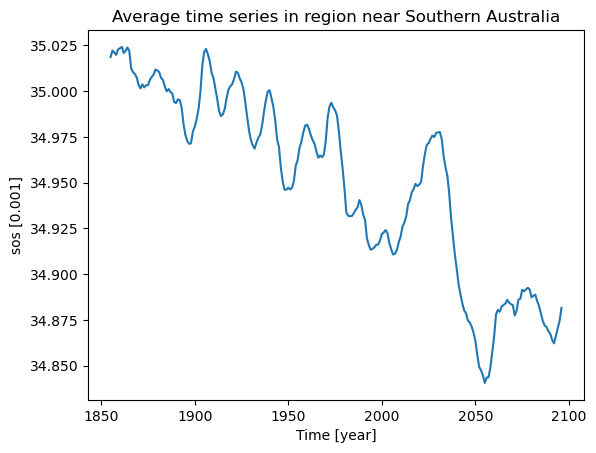

In [25]:
x_values = [t.year for t in calculator.ds_local["time"].values]
y_values = calculator.weigthed_mean_cached(calculator.field_rm)

plt.plot(x_values, y_values)
plt.ylabel(
    f'{calculator.field} [{calculator.ds_local[calculator.field].attrs["units"]}]'
)
plt.xlabel("Time [year]")
plt.title('Average time series in region near Southern Australia')

### Checking all masks of the previous method

Below, we will try all masks using `optim_esm_tools.analyze.merge_candidate_regions.Merger` - an iterative routine that tries each mask seperatly. Then, it tries combining masks that pass with any other mask.

To showcase how it works, we will just for now use a different pass criteria, that the `max_jump > 4.5` so that we get a few regions that pass and merge a few sets.

In [26]:
merger = oet.analyze.merge_candidate_regions.Merger(
    
    # Normally this would read:
    # pass_criteria=passes_2024_11,
    # For educative purposes, we use something less strict
    pass_criteria=lambda max_jump, **kw: max_jump>4.5,
    
    # Wrapper for RegionPropertyCalculator
    summary_calculation=oet.analyze.region_calculation.summarize_stats,
    
    # We need to have the masked sets here (ds_local of the RegionPropertyCalculator-arguments)
    data_sets=[oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask) for mask in masks],
    
    # All masks have the same his+ssp and pi dataset.
    common_mother=ds_his_ssp,
    common_pi=ds_pi,
    
    # Merge options, let's set them to be very lenient. Now, we will merge them as soon as 0.1% of the
    # grid cells of two regions are adjacent (so basically always merge passing adjacent regions if they)
    # fullfill the pass_criteria
    merge_options = dict(min_border_frac=0.001)
)

In [27]:
merged = merger.merge_datasets()

Looping candidates:   0%|          | 0/7 [00:00<?, ?it/s]

03-20 13:23:13 | oet          | WARNING  | Breaking forcefully | merge_datasets (l. 236)


We now have this many merged regions that have an average `max_jump` that passes our dummy criterion, let's show them on one global mask

In [28]:
len(merged)

3

Text(0.5, 1.0, 'Merged regions')

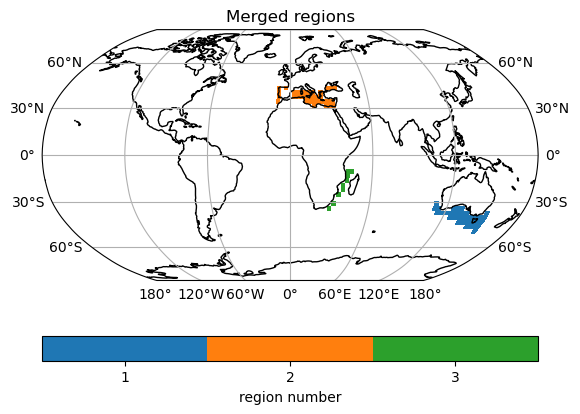

In [29]:
# Get an empty 2d DataArray
merged_global_mask = ds_his_ssp["cell_area"].copy().astype(np.float64)
merged_global_mask[:] = np.nan

for i, ds_merged in enumerate(merged):
    # Unfortunatly, 2d-indexing is not great in xarray, so let's revert to numpy indexing
    v = merged_global_mask.values
    v[ds_merged["ds"]["global_mask"].values] = i + 1

    merged_global_mask.data = v
oet.plotting.plot.plot_da(
    merged_global_mask,
    cmap=plt.cm.tab10,
    vmin=0.5,
    vmax=10.5,
    cbar_kwargs=dict(orientation="horizontal", label="region number"),
)

# plt.show()
used_numbers = np.arange(len(merged)) + 1
plt.gcf().axes[1].set_xticks(used_numbers, used_numbers)
plt.gcf().axes[1].set_xlim(used_numbers[0] - 0.5, used_numbers[-1] + 0.5)
plt.title("Merged regions")

### Result:

We now see that two regions (go back to [Region isolation](#2.-Region-isolation)) are merged for Southern Africa (Reg. 4 and Reg. 5). The region near Western South America does not pass the simple `max_jump>4.5` criterium and neither do the Mediteranian or North American regions. They are therefore not merged.

We can look at their spatially averaged time series:

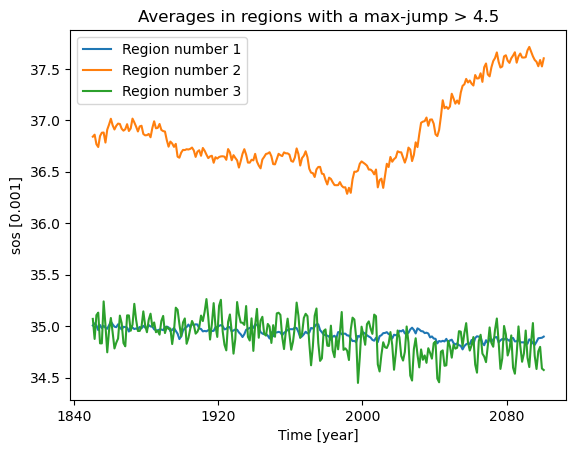

In [30]:
for i, doc_merged in enumerate(merged):
    doc_merged["ds"][calculator.field].mean("lat lon".split()).plot(
        label=f"Region number {i+1}"
    )
plt.ylabel(
    f'{calculator.field} [{calculator.ds_local[calculator.field].attrs["units"]}]'
)
plt.xlabel("Time [year]")
plt.title("Averages in regions with a max-jump > 4.5")
plt.legend()

## 4. Full-scale workflow

The example above is simple and fast to run, we will now will reproduce the setup also used in `2024_11_11_dramatic_shifts_v17_compressed.pdf`.

First we need to setup the config for the region finding:

In [31]:
extra_opt = dict(
    iter_mask_min_area=1e6 * 1e6,  # m^2!,
    cluster_method="masked",
    iterable_range=dict(
        percentiles=np.linspace(99.99, 85, 61),
        product_percentiles=np.linspace(99.9, 85, 61),
        n_times_historical=np.linspace(8, 2.5, 61),
    ),
    iter_mask_max_area=999e12,
    force_continuity=True,
)

### Region finding
We use four methods to find regions of at least $10^{6}\,km^2$. Please see `2024_11_11_dramatic_shifts_v17_compressed.pdf` or each of the four classes for more detail.


#### filter out small masks

Notice the `worker.filter_masks_and_clusters` which removes any masks that are smaller in size than the `iter_mask_min_area`.

In [32]:
masks = []
for method in oet.utils.tqdm(
    [
        oet.region_finding.IterProductPercentiles,
        oet.region_finding.IterPercentiles,
        oet.region_finding.IterLocalHistory,
        oet.region_finding.IterStartEnd,
    ]
):
    kw = dict(
        variable=None,
        data_set=ds_ssp,
        save_kw=dict(
            skip=True,
            save_in="./",
            file_types=("png",),
            sub_dir=None,
        ),
        extra_opt=extra_opt,
    )
    if "data_set_pic" in inspect.getfullargspec(method.__init__).kwonlyargs:
        kw.update(
            data_set_pic=ds_pi,
        )
    worker = method(**kw)
    masks_and_clusters = worker.get_masks()
    masks_from_this_method, _ = worker.filter_masks_and_clusters(masks_and_clusters)
    masks += masks_from_this_method
    print(f"{method.__name__:30} finds {len(masks_from_this_method)} masks")

  0%|          | 0/4 [00:00<?, ?it/s]

IterProductPercentiles         finds 5 masks
IterPercentiles                finds 7 masks
IterLocalHistory               finds 2 masks
IterStartEnd                   finds 6 masks


In [33]:
len(masks)

20

### Merge the masks
Now we merge the masks if at least one of the masks is passing and the combination will also pass the criteria. The idea is similar to before.

In [34]:
merger = oet.analyze.merge_candidate_regions.MergerCached(
    pass_criteria=passes_2024_11,
    summary_calculation=oet.analyze.region_calculation.summarize_stats,
    data_sets=[
        oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask)
        for mask in masks
    ],
    common_mother=ds_his_ssp,
    common_pi=ds_pi,
)

In [35]:
oet.get_logger().setLevel("ERROR")
merged = merger.merge_datasets()
oet.get_logger().setLevel("WARNING")

Looping candidates:   0%|          | 0/20 [00:00<?, ?it/s]

checking at least one passes:   0%|          | 0/6 [00:00<?, ?it/s]

merging iteratively:   0%|          | 0/19 [00:00<?, ?it/s]

In [36]:
len(merged)

1

In [37]:
assert len(merged), "This example is not complete since we don't have a passing example"

### Check the merged region

/home/aangevaare/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: overflow encountered in cast
  return data.astype(dtype, **kwargs)


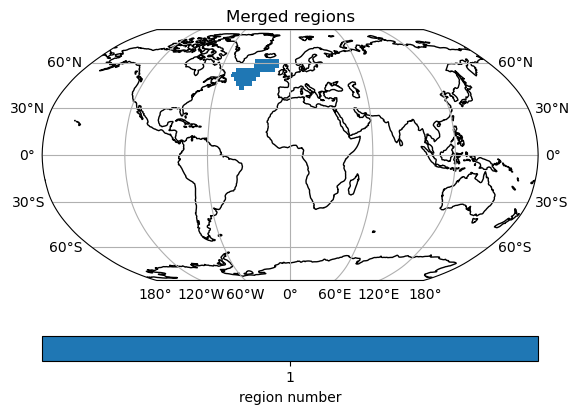

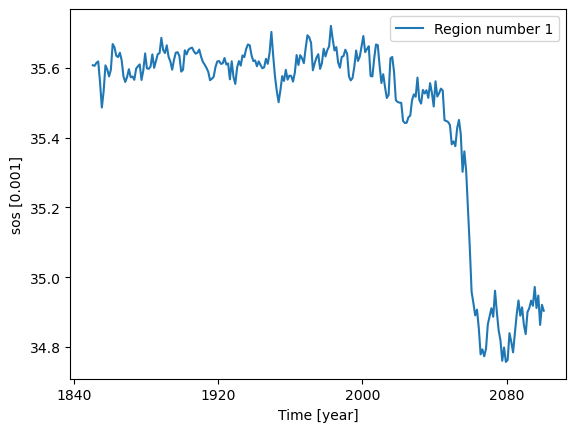

In [38]:
def display_merged_result(ds_his_ssp, merged):
    merged_global_mask = ds_his_ssp["cell_area"].copy().astype(np.float16)
    merged_global_mask[:] = np.nan

    for i, ds_merged in enumerate(merged):
        # Unfortunatly, 2d-indexing is not great in xarray, so let's revert to numpy indexing
        v = merged_global_mask.values
        v[ds_merged["ds"]["global_mask"].values] = i + 1

        merged_global_mask.data = v
    oet.plotting.plot.plot_da(
        merged_global_mask,
        cmap=plt.cm.tab10,
        vmin=0.5,
        vmax=10.5,
        cbar_kwargs=dict(orientation="horizontal", label="region number"),
    )

    used_numbers = np.arange(len(merged)) + 1
    plt.gcf().axes[1].set_xticks(used_numbers, used_numbers)
    plt.gcf().axes[1].set_xlim(used_numbers[0] - 0.5, used_numbers[-1] + 0.5)
    plt.title("Merged regions")
    plt.show()

    for i, doc_merged in enumerate(merged):
        doc_merged["ds"][calculator.field].mean("lat lon".split()).plot(
            label=f"Region number {i+1}"
        )
    plt.ylabel(
        f'{calculator.field} [{calculator.ds_local[calculator.field].attrs["units"]}]'
    )
    plt.xlabel("Time [year]")
    plt.title("")
    plt.legend()
    plt.show()


display_merged_result(ds_his_ssp, merged)

### Adding many small-scale submasks

In addition to the 31 masks above, we add add a lot of small groups with only a hand full of grid points, these may be added to the large masks. In order to save computational time, we pre-set the calculation of all these masks to something that would not pass the criteria we are using. While we could most likely build a region from the set of small masks, these would be filtered out in `worker.filter_masks_and_clusters` because they are only a few grid cells.

In [39]:
small_masks, _ = oet.region_finding.MaskAll(**kw).get_masks()

In [40]:
large_regions = [
    oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask) for mask in masks
]
small_regions = [
    oet.analyze.xarray_tools.mask_to_reduced_dataset(ds_his_ssp, mask) for mask in small_masks
]

In [41]:
merger = oet.analyze.merge_candidate_regions.MergerCached(
    pass_criteria=passes_2024_11,
    summary_calculation=oet.analyze.region_calculation.summarize_stats,
    data_sets=large_regions + small_regions,
    common_mother=ds_his_ssp,
    common_pi=ds_pi,
)

Now in the class we are using, skip the computation for the small-masks, theay are all set to False (i.e. they are not passing the criteria). They only become relevant if they are adjacent or overlapping with a passing region.

This does save a lot of computation time (it is about $\sim20\times$ faster).

In [42]:
merger.set_all_caches_as_false(small_masks)

In [43]:
oet.get_logger().setLevel("ERROR")
merged = merger.merge_datasets()
oet.get_logger().setLevel("WARNING")

Looping candidates:   0%|          | 0/262 [00:00<?, ?it/s]

checking at least one passes:   0%|          | 0/253 [00:00<?, ?it/s]

merging iteratively:   0%|          | 0/261 [00:00<?, ?it/s]

## Inspect the merged result
We see that it's very similar to the region we had before, now just slightly enlarged by the small-masks that we added manually.

/home/aangevaare/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:187: RuntimeWarning: overflow encountered in cast
  return data.astype(dtype, **kwargs)


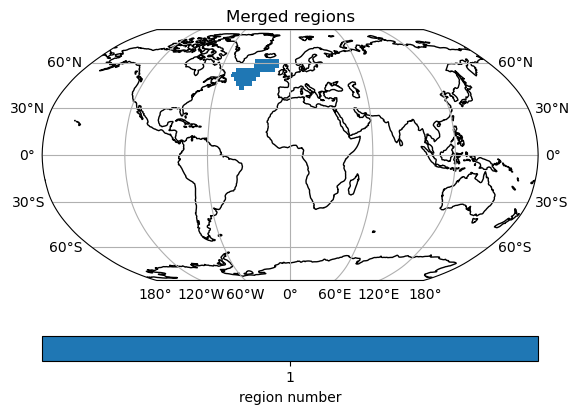

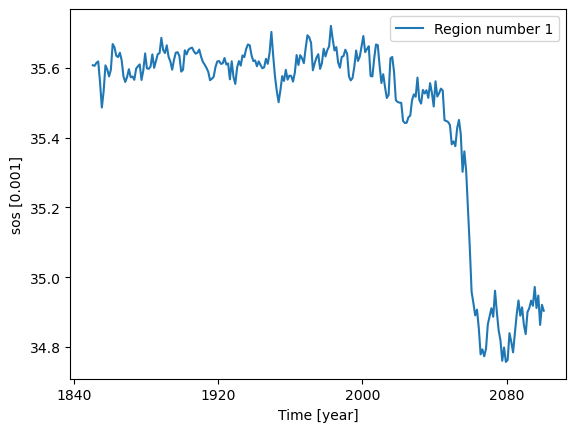

In [44]:
display_merged_result(ds_his_ssp, merged)

In [45]:
end = !date

In [46]:
datefmt = "%a %b %d %H:%M:%S %Z %Y"

print(f'Started at {start[0]}, finished at {end[0]}')
dt = datetime.datetime.strptime(end[0], datefmt) - datetime.datetime.strptime(
    start[0], datefmt
)
print(f'Took {dt.total_seconds()/60:.1f} m')

Started at Thu Mar 20 13:22:57 CET 2025, finished at Thu Mar 20 13:23:38 CET 2025
Took 0.7 m
